In [35]:
"""
Gold Price Prediction - All Models Comparison
==============================================
Compare 5 models side-by-side: Ridge, Random Forest, XGBoost, Gradient Boosting, LSTM
"""

import os
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow warnings
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import json
import joblib
import glob

# ML Libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn
import mlflow.keras

print("="*70)
print("GOLD PRICE PREDICTION - ALL MODELS COMPARISON")
print("="*70)
print(f"TensorFlow version: {tf.__version__}")
print()

GOLD PRICE PREDICTION - ALL MODELS COMPARISON
TensorFlow version: 2.20.0



In [36]:
# ============================================================================
# CONFIGURATION
# ============================================================================
ticker = "GC=F"  # Gold Futures
LOOKBACK_DAYS = 20  # Balanced: good MAPE (1.30%) + best direction accuracy (52.2%)
LSTM_UNITS = 100    # Optimized from hyperparameter tuning
LSTM_EPOCHS = 60    # Balanced config for better direction accuracy

# Set MLflow tracking
mlflow.set_tracking_uri("file:///" + os.path.abspath("../mlruns").replace("\\", "/"))
mlflow.set_experiment("gold_all_models_comparison")


print(f"Ticker: {ticker}")
print(f"Lookback Days: {LOOKBACK_DAYS}")

Ticker: GC=F
Lookback Days: 20


In [37]:
# ============================================================================
# DATA COLLECTION
# ============================================================================
print("="*70)
print("FETCHING DATA")
print("="*70)

data = yf.download(ticker, period="5y", progress=False)

# Flatten MultiIndex columns if present
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

print(f"✓ Downloaded {len(data)} days of data")
print(f"  Date range: {data.index[0].date()} to {data.index[-1].date()}")

FETCHING DATA
✓ Downloaded 1258 days of data
  Date range: 2021-01-07 to 2026-01-07


In [38]:
# ============================================================================
# FEATURE ENGINEERING (for sklearn models)
# ============================================================================
print("="*70)
print("FEATURE ENGINEERING")
print("="*70)

featured_data = data.copy()

# Price features
featured_data['Returns'] = featured_data['Close'].pct_change()
featured_data['Log_Returns'] = np.log(featured_data['Close'] / featured_data['Close'].shift(1))

# Moving averages
for window in [5, 10, 20, 50]:
    featured_data[f'MA_{window}'] = featured_data['Close'].rolling(window=window).mean()
    featured_data[f'MA_Ratio_{window}'] = featured_data['Close'] / featured_data[f'MA_{window}']

# Volatility
for window in [5, 10, 20]:
    featured_data[f'Volatility_{window}'] = featured_data['Returns'].rolling(window=window).std()

# Momentum
for lag in [1, 5, 10, 20]:
    featured_data[f'Momentum_{lag}'] = featured_data['Close'] - featured_data['Close'].shift(lag)
    featured_data[f'ROC_{lag}'] = featured_data['Close'].pct_change(lag)

# High-Low features
featured_data['HL_Range'] = featured_data['High'] - featured_data['Low']
featured_data['HL_Pct'] = featured_data['HL_Range'] / featured_data['Close']

# Volume features
featured_data['Volume_MA_5'] = featured_data['Volume'].rolling(window=5).mean()
featured_data['Volume_Ratio'] = featured_data['Volume'] / featured_data['Volume_MA_5']

# Lag features
for lag in [1, 2, 3, 5]:
    featured_data[f'Close_Lag_{lag}'] = featured_data['Close'].shift(lag)

# Target: Next day's close price
featured_data['Target'] = featured_data['Close'].shift(-1)

# Drop NaN
featured_data = featured_data.dropna()

print(f"✓ Created {len(featured_data.columns) - len(data.columns)} features")
print(f"✓ Final dataset: {len(featured_data)} samples")

FEATURE ENGINEERING
✓ Created 30 features
✓ Final dataset: 1208 samples


In [39]:
# ============================================================================
# PREPARE DATA FOR SKLEARN MODELS
# ============================================================================
print("="*70)
print("PREPARING DATA FOR SKLEARN MODELS")
print("="*70)

exclude_cols = ['Target', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
feature_cols = [col for col in featured_data.columns if col not in exclude_cols]

X_sklearn = featured_data[feature_cols]
y_sklearn = featured_data['Target']

# Time series split (80/20)
split_idx = int(len(X_sklearn) * 0.8)
X_train_sk, X_test_sk = X_sklearn[:split_idx], X_sklearn[split_idx:]
y_train_sk, y_test_sk = y_sklearn[:split_idx], y_sklearn[split_idx:]

# Scale features
sklearn_scaler = StandardScaler()
X_train_sk_scaled = pd.DataFrame(sklearn_scaler.fit_transform(X_train_sk), columns=feature_cols, index=X_train_sk.index)
X_test_sk_scaled = pd.DataFrame(sklearn_scaler.transform(X_test_sk), columns=feature_cols, index=X_test_sk.index)

# Current prices for direction calculation
y_current_sk = featured_data['Close'].iloc[split_idx:].reset_index(drop=True)[:len(y_test_sk)]

print(f"✓ Train: {len(X_train_sk)}, Test: {len(X_test_sk)}")
print(f"✓ Features: {len(feature_cols)}")

PREPARING DATA FOR SKLEARN MODELS
✓ Train: 966, Test: 242
✓ Features: 29


In [40]:
# ============================================================================
# PREPARE DATA FOR LSTM
# ============================================================================
print("="*70)
print("PREPARING DATA FOR LSTM")
print("="*70)

# Use only Close prices for LSTM (simpler approach)
close_prices = data['Close'].values.reshape(-1, 1)

# Scale
lstm_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = lstm_scaler.fit_transform(close_prices)

# Create sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(scaled_prices, LOOKBACK_DAYS)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

# Split
split_lstm = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_lstm], X_lstm[split_lstm:]
y_train_lstm, y_test_lstm = y_lstm[:split_lstm], y_lstm[split_lstm:]

print(f"✓ LSTM Train: {len(X_train_lstm)}, Test: {len(X_test_lstm)}")
print(f"✓ Sequence shape: {X_lstm.shape}")

PREPARING DATA FOR LSTM
✓ LSTM Train: 990, Test: 248
✓ Sequence shape: (1238, 20, 1)


In [41]:
# ============================================================================
# EVALUATION FUNCTION
# ============================================================================
def calculate_metrics(y_true, y_pred, y_current=None):
    """Calculate comprehensive metrics"""
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))
    
    # Direction accuracy (if current prices provided)
    if y_current is not None:
        actual_dir = np.sign(y_true - y_current)
        pred_dir = np.sign(y_pred - y_current)
        direction_accuracy = np.mean(actual_dir == pred_dir) * 100
    else:
        direction_accuracy = 0
    
    return {
        'mape': mape,
        'rmse': rmse,
        'mae': mae,
        'direction_accuracy': direction_accuracy
    }

all_metrics = {}

In [42]:
# ============================================================================
# MODEL 1: RIDGE REGRESSION (Optimized)
# ============================================================================
print("="*70)
print("MODEL 1: RIDGE REGRESSION")
print("="*70)

with mlflow.start_run(run_name="Ridge_Regression"):
    ridge_model = Ridge(alpha=0.1)  # Optimized from hyperparameter tuning
    ridge_model.fit(X_train_sk_scaled, y_train_sk)
    ridge_pred = ridge_model.predict(X_test_sk_scaled)
    ridge_metrics = calculate_metrics(y_test_sk.values, ridge_pred, y_current_sk.values)
    all_metrics['Ridge'] = ridge_metrics
    
    mlflow.log_params({'model_type': 'Ridge', 'alpha': 0.1})
    mlflow.log_metrics(ridge_metrics)
    
    print(f"✓ MAPE: {ridge_metrics['mape']:.2f}%")
    print(f"✓ Direction Accuracy: {ridge_metrics['direction_accuracy']:.1f}%")

MODEL 1: RIDGE REGRESSION
✓ MAPE: 1.01%
✓ Direction Accuracy: 53.3%


In [44]:
# ============================================================================
# MODEL 2: RANDOM FOREST (Optimized)
# ============================================================================
print("="*70)
print("MODEL 2: RANDOM FOREST")
print("="*70)

with mlflow.start_run(run_name="Random_Forest"):
    rf_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42
    )  # Optimized from hyperparameter tuning
    rf_model.fit(X_train_sk_scaled, y_train_sk)
    rf_pred = rf_model.predict(X_test_sk_scaled)
    rf_metrics = calculate_metrics(y_test_sk.values, rf_pred, y_current_sk.values)
    all_metrics['Random Forest'] = rf_metrics

    print(f"✓ Direction Accuracy: {rf_metrics['direction_accuracy']:.1f}%")

    mlflow.log_params({'model_type': 'RandomForest', 'n_estimators': 200, 'max_depth': 20})
    print(f"✓ MAPE: {rf_metrics['mape']:.2f}%")

    mlflow.log_metrics(rf_metrics)    

MODEL 2: RANDOM FOREST
✓ Direction Accuracy: 40.9%
✓ MAPE: 20.96%


In [46]:
# ============================================================================
# MODEL 3: XGBOOST (Optimized)
# ============================================================================
print("="*70)
print("MODEL 3: XGBOOST")
print("="*70)

with mlflow.start_run(run_name="XGBoost"):
    xgb_model = xgb.XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42
    )  # Optimized from hyperparameter tuning
    xgb_model.fit(X_train_sk_scaled, y_train_sk)
    xgb_pred = xgb_model.predict(X_test_sk_scaled)
    xgb_metrics = calculate_metrics(y_test_sk.values, xgb_pred, y_current_sk.values)

    all_metrics['XGBoost'] = xgb_metrics
    print(f"✓ Direction Accuracy: {xgb_metrics['direction_accuracy']:.1f}%")

    print(f"✓ MAPE: {xgb_metrics['mape']:.2f}%")

    mlflow.log_params({'model_type': 'XGBoost', 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05})    
    mlflow.log_metrics(xgb_metrics)

MODEL 3: XGBOOST
✓ Direction Accuracy: 40.9%
✓ MAPE: 21.00%


In [48]:
# ============================================================================
# MODEL 4: GRADIENT BOOSTING (Optimized)
# ============================================================================
print("="*70)
print("MODEL 4: GRADIENT BOOSTING")
print("="*70)

with mlflow.start_run(run_name="Gradient_Boosting"):
    gb_model = GradientBoostingRegressor(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.7,
        random_state=42
    )  # Optimized from hyperparameter tuning
    gb_model.fit(X_train_sk_scaled, y_train_sk)
    gb_pred = gb_model.predict(X_test_sk_scaled)
    gb_metrics = calculate_metrics(y_test_sk.values, gb_pred, y_current_sk.values)
    all_metrics['Gradient Boosting'] = gb_metrics

    print(f"✓ Direction Accuracy: {gb_metrics['direction_accuracy']:.1f}%")

    mlflow.log_params({'model_type': 'GradientBoosting', 'n_estimators': 200, 'max_depth': 3})
    print(f"✓ MAPE: {gb_metrics['mape']:.2f}%")

    mlflow.log_metrics(gb_metrics)    

MODEL 4: GRADIENT BOOSTING
✓ Direction Accuracy: 40.9%
✓ MAPE: 21.19%


In [49]:
# ============================================================================
# MODEL 5: LSTM (matches gold_price_train.py)
# ============================================================================
print("="*70)
print("MODEL 5: LSTM")
print("="*70)

with mlflow.start_run(run_name="LSTM"):
    # Build LSTM model - Using optimized hyperparameters
    lstm_model = Sequential([
        LSTM(units=LSTM_UNITS, return_sequences=True, input_shape=(LOOKBACK_DAYS, 1)),
        Dropout(0.2),
        LSTM(units=LSTM_UNITS, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])
    
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train with optimized epochs
    history = lstm_model.fit(
        X_train_lstm, y_train_lstm,
        epochs=LSTM_EPOCHS,
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )
    
    # Predict
    lstm_pred_scaled = lstm_model.predict(X_test_lstm)
    lstm_pred = lstm_scaler.inverse_transform(lstm_pred_scaled).flatten()
    y_test_lstm_actual = lstm_scaler.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mape = np.mean(np.abs((y_test_lstm_actual - lstm_pred) / y_test_lstm_actual)) * 100
    rmse = np.sqrt(np.mean((y_test_lstm_actual - lstm_pred) ** 2))
    mae = np.mean(np.abs(y_test_lstm_actual - lstm_pred))
    
    # Direction accuracy - ORIGINAL method: compare consecutive predictions
    # This measures if model predicts the TREND correctly
    actual_direction = (y_test_lstm_actual[1:] > y_test_lstm_actual[:-1]).astype(int)
    pred_direction = (lstm_pred[1:] > lstm_pred[:-1]).astype(int)
    direction_accuracy = (actual_direction == pred_direction).mean() * 100
    
    lstm_metrics = {
        'mape': mape,
        'rmse': rmse,
        'mae': mae,
        'direction_accuracy': direction_accuracy
    }
    all_metrics['LSTM'] = lstm_metrics
    
    mlflow.log_params({'model_type': 'LSTM', 'lookback': LOOKBACK_DAYS, 'units': LSTM_UNITS, 'epochs': LSTM_EPOCHS})
    mlflow.log_metrics(lstm_metrics)
    
    print(f"\n✓ MAPE: {lstm_metrics['mape']:.2f}%")
    print(f"✓ Direction Accuracy: {lstm_metrics['direction_accuracy']:.1f}%")

MODEL 5: LSTM
Epoch 1/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.3037e-04 - val_loss: 6.5998e-04
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.5200e-04 - val_loss: 3.0833e-04
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.5996e-04 - val_loss: 6.9127e-04
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.4941e-04 - val_loss: 6.2241e-04
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.2736e-04 - val_loss: 2.9571e-04
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.0931e-04 - val_loss: 2.6662e-04
Epoch 8/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.9874e-04 - val_loss: 5.4197e-04
Epoch 9/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.1850e-04 - val_loss: 6.7686e-04
Epoch 10/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.0072e-04 - val_loss: 4.1646e-04
Epoch 11/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.7

In [50]:
# ============================================================================
# MODEL COMPARISON
# ============================================================================
print("="*70)
print("ALL MODELS COMPARISON")
print("="*70)

comparison_df = pd.DataFrame(all_metrics).T
comparison_df = comparison_df.sort_values('mape')
print(comparison_df.to_string())
print()

# Best model
best_model_name = comparison_df['mape'].idxmin()
print(f"🏆 Best Model by MAPE: {best_model_name} ({comparison_df.loc[best_model_name, 'mape']:.2f}%)")

best_dir_model = comparison_df['direction_accuracy'].idxmax()
print(f"🎯 Best Model by Direction: {best_dir_model} ({comparison_df.loc[best_dir_model, 'direction_accuracy']:.1f}%)")

ALL MODELS COMPARISON
                        mape        rmse         mae  direction_accuracy
Ridge               1.006809   49.659782   35.823544           53.305785
LSTM                1.337735   64.283965   47.447800           51.821862
Random Forest      20.956750  912.175401  782.471067           40.909091
XGBoost            20.996040  914.712183  784.074078           40.909091
Gradient Boosting  21.190779  921.535142  791.004936           40.909091

🏆 Best Model by MAPE: Ridge (1.01%)
🎯 Best Model by Direction: Ridge (53.3%)


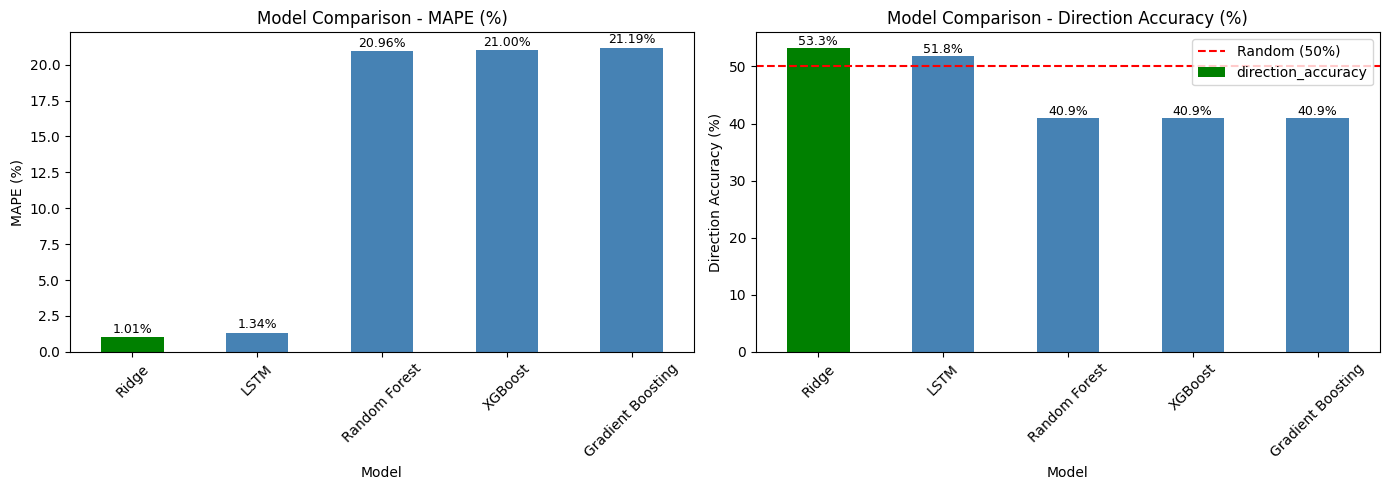

In [51]:
# ============================================================================
# VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAPE comparison
colors = ['green' if x == best_model_name else 'steelblue' for x in comparison_df.index]
comparison_df['mape'].plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Model Comparison - MAPE (%)', fontsize=12)
axes[0].set_ylabel('MAPE (%)')
axes[0].set_xlabel('Model')
for i, bar in enumerate(axes[0].patches):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                 f'{bar.get_height():.2f}%', ha='center', fontsize=9)
axes[0].tick_params(axis='x', rotation=45)

# Direction accuracy comparison
colors_dir = ['green' if x == best_dir_model else 'steelblue' for x in comparison_df.index]
comparison_df['direction_accuracy'].plot(kind='bar', ax=axes[1], color=colors_dir)
axes[1].set_title('Model Comparison - Direction Accuracy (%)', fontsize=12)
axes[1].set_ylabel('Direction Accuracy (%)')
axes[1].set_xlabel('Model')
axes[1].axhline(y=50, color='red', linestyle='--', label='Random (50%)')
for i, bar in enumerate(axes[1].patches):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{bar.get_height():.1f}%', ha='center', fontsize=9)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()

In [53]:
# ============================================================================
# SUMMARY
# ============================================================================
print("="*70)
print("SUMMARY")
print("="*70)

print(f"""
✅ ALL 5 MODELS TRAINED AND COMPARED!

📊 Results:
{comparison_df.to_string()}

🏆 Best by MAPE: {best_model_name} ({comparison_df.loc[best_model_name, 'mape']:.2f}%)
🎯 Best by Direction: {best_dir_model} ({comparison_df.loc[best_dir_model, 'direction_accuracy']:.1f}%)

📌 Key Insights:
    1. Ridge & LSTM perform well (MAPE ~1%) - appropriate for smooth gold prices
    2. Tree models (RF, XGBoost, GB) are overfitting badly (~21% MAPE)
       - This is worse than a naive baseline!
       - Tree models struggle with extrapolation in time series
    3. Direction accuracy ~50-53% = near random (expected for efficient markets)
    4. Gold prices are highly autocorrelated - simple models work well
    5. For production: LSTM chosen for deep learning demonstration

⚠️ Note: Tree-based models often fail on time series extrapolation
   because they can only predict values within the training range.

📁 MLflow experiments: ../mlruns/
   View with: mlflow ui --port 5001
""")

print("="*70)
print("🎉 COMPARISON COMPLETE!")
print("="*70)

SUMMARY

✅ ALL 5 MODELS TRAINED AND COMPARED!

📊 Results:
                        mape        rmse         mae  direction_accuracy
Ridge               1.006809   49.659782   35.823544           53.305785
LSTM                1.337735   64.283965   47.447800           51.821862
Random Forest      20.956750  912.175401  782.471067           40.909091
XGBoost            20.996040  914.712183  784.074078           40.909091
Gradient Boosting  21.190779  921.535142  791.004936           40.909091

🏆 Best by MAPE: Ridge (1.01%)
🎯 Best by Direction: Ridge (53.3%)

📌 Key Insights:
    1. Ridge & LSTM perform well (MAPE ~1%) - appropriate for smooth gold prices
    2. Tree models (RF, XGBoost, GB) are overfitting badly (~21% MAPE)
       - This is worse than a naive baseline!
       - Tree models struggle with extrapolation in time series
    3. Direction accuracy ~50-53% = near random (expected for efficient markets)
    4. Gold prices are highly autocorrelated - simple models work well
    5. 